数据分析
（1）outliers分析 通常是从常识、逻辑、经验以及事实出发分析 相违背的
比如 经纬度 NYC的城市边界经纬度范围可以判断经纬度属性数据是否准确

Import some libraries
导入包

In [73]:
%matplotlib inline
import pandas as pd
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib
import numpy as np

import time

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

In [74]:
ISOTIMEFORMAT='%Y-%m-%d %X'
print time.strftime( ISOTIMEFORMAT, time.localtime( time.time() ) )

2017-08-24 22:44:42


Load data

In [75]:
train = pd.read_csv("F:/Mine/MachineLearning/ML_in_Python/ML-projects/kaggle-NYC_Taxi/train.csv")
test = pd.read_csv("F:/Mine/MachineLearning/ML_in_Python/ML-projects/kaggle-NYC_Taxi/test.csv")

初始数据分析

In [76]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [77]:
# 发现了一些outliers we need to deal with
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [78]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


数据准备

属性分析s：
（1）首先把pickup_datatime 里的hour、day、month提取出来
因为每天的高峰时段（hour）以及是否周末、不同月份的天气状况等会导致不一样的行车速度和时间：
高峰时间慢、冬季地滑慢等等
（2）很有意思的属性：乘客数量
乘客数量多的话可能会导致停车次数增多 会增加时间；
当然了 乘客数量增多 车的质量变大 行驶速度也会缓慢 当然这点可能会忽略不计
（3）很有可能vendor供应商不同也会不同 因为两家的雇员对于选择最短路径的经验不同 当然可能性不是很大 但是也可作为一个备选的属性进行深入研究
（4）最有价值的属性还是 上下车经纬度 


用标准差来clean-up trip duration中的outliers数据

In [79]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

Latitude & Longitude Clean-up 
经纬度数据清理
深入了解发现：NYC的边界的经纬度范围为：
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85) 

In [80]:
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

date属性 clean-up 
初步特征工程

In [81]:
# 先转换成 datetime之后才进行进一步reformat
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime) #Not in Test

Data visualization and analysis
数据可视化分析

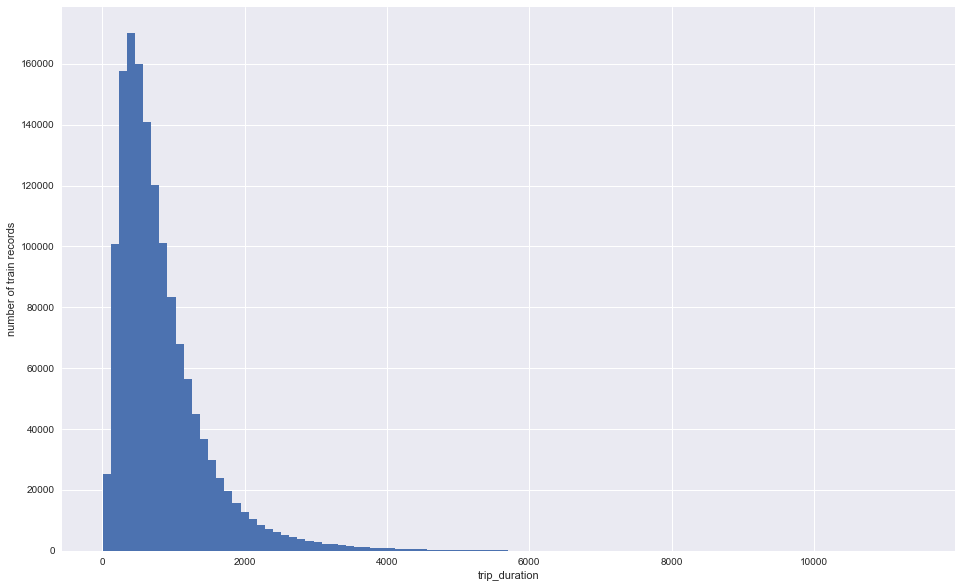

In [82]:
plt.hist(train['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

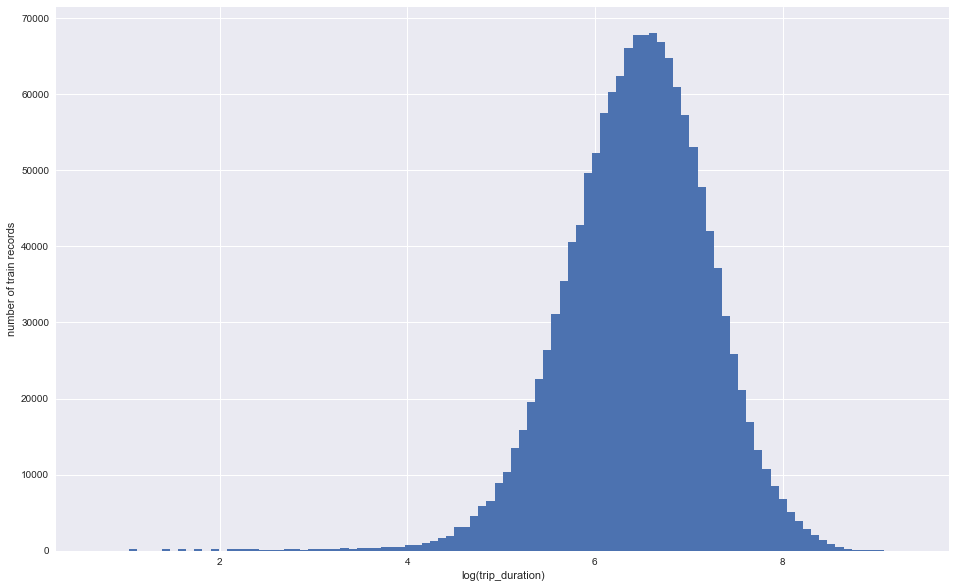

In [83]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

In [84]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,log_trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,6.077642


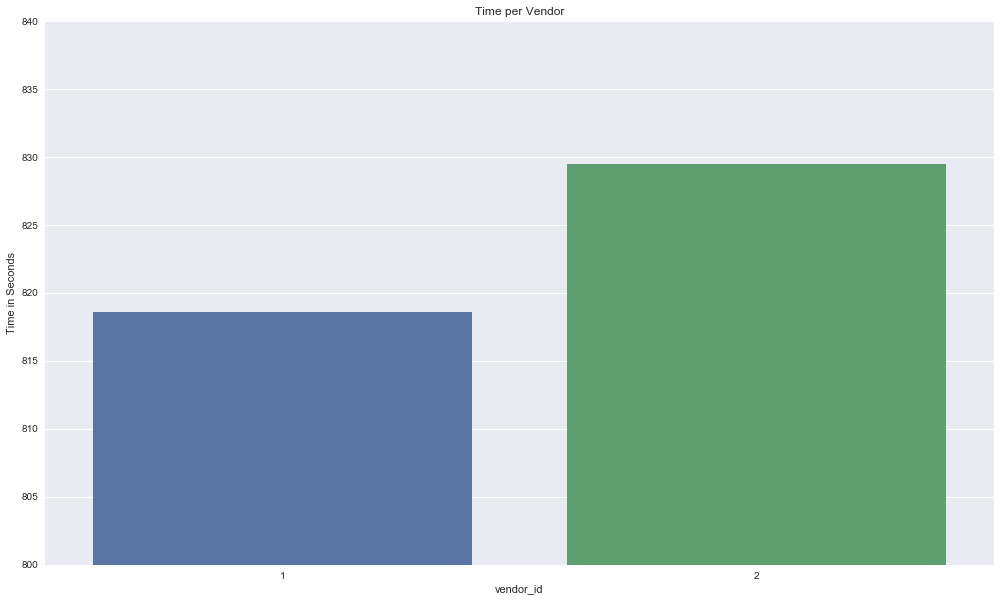

In [85]:
import warnings
warnings.filterwarnings("ignore")
plot_vendor = train.groupby('vendor_id')['trip_duration'].mean()
plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=800)
plt.ylim(ymax=840)
sns.barplot(plot_vendor.index,plot_vendor.values)
plt.title('Time per Vendor')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')

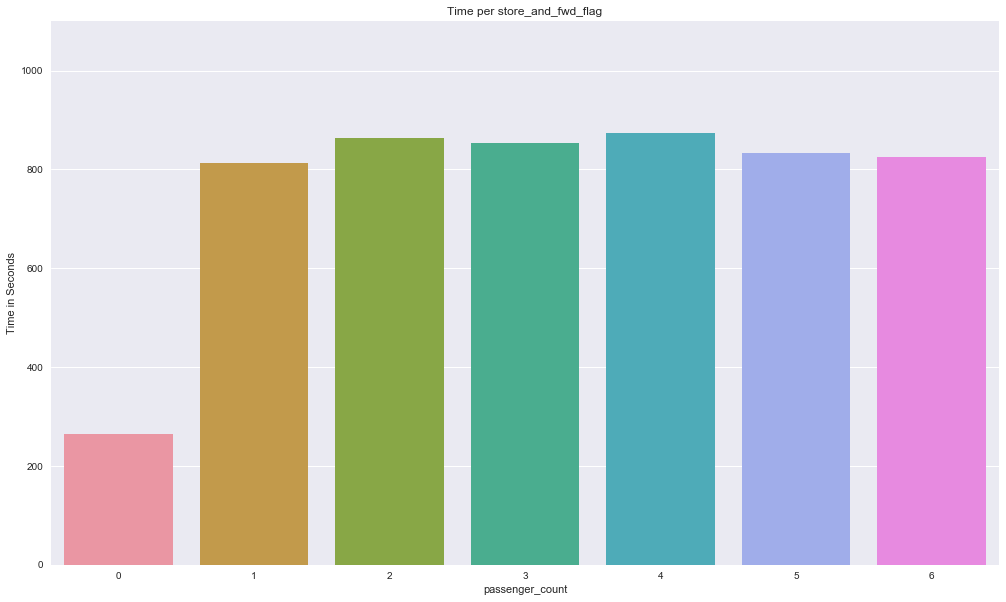

In [86]:
pc = train.groupby('passenger_count')['trip_duration'].mean()

plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(pc.index,pc.values)

In [87]:
train.groupby('passenger_count').size()

passenger_count
0         52
1    1018715
2     206864
3      58989
4      27957
5      76912
6      47639
dtype: int64

In [88]:
test.groupby('passenger_count').size()

passenger_count
0        23
1    443447
2     90027
3     25686
4     12017
5     33411
6     20521
9         2
dtype: int64

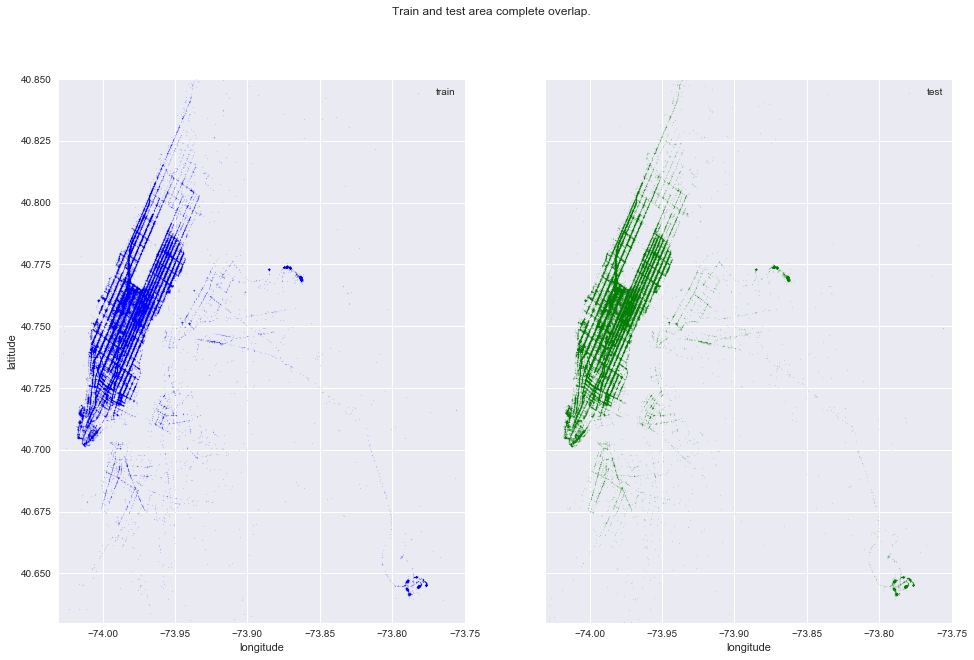

In [89]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:100000], train['pickup_latitude'].values[:100000],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:100000], test['pickup_latitude'].values[:100000],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

利用havesine 计算distance及direction make neighbouhood 街区 
用kmeans进行聚类得到

In [90]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [91]:
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)    
    
train.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

In [92]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))


In [93]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [94]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

In [95]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,log_trip_duration,distance_haversine,distance_dummy_manhattan,direction,pickup_cluster,dropoff_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,6.122493,1.498521,1.735433,99.970196,96,83
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,6.498282,1.805507,2.430506,-117.153768,12,92
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,7.661527,6.385098,8.203575,-159.680165,47,8
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,6.063785,1.485498,1.661331,-172.737700,27,8
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,6.077642,1.188588,1.199457,179.473585,39,84


In [96]:
#Extracting Month
train['Month'] = train['pickup_datetime'].dt.month
test['Month'] = test['pickup_datetime'].dt.month

In [97]:
train.groupby('Month').size(),test.groupby('Month').size()

(Month
 1    226444
 2    235054
 3    252443
 4    247855
 5    244591
 6    230741
 dtype: int64, Month
 1     97676
 2    102314
 3    109697
 4    107432
 5    107570
 6    100445
 dtype: int64)

In [98]:
train['DayofMonth'] = train['pickup_datetime'].dt.day
test['DayofMonth'] = test['pickup_datetime'].dt.day
len(train.groupby('DayofMonth').size()),len(test.groupby('DayofMonth').size())

(31, 31)

In [99]:
train.groupby('DayofMonth').size()

DayofMonth
1     45824
2     47069
3     47225
4     48911
5     49456
6     48794
7     48019
8     47536
9     48925
10    48125
11    48192
12    49383
13    48620
14    49798
15    49103
16    50301
17    48171
18    47188
19    48551
20    48495
21    47520
22    46569
23    40843
24    43162
25    45736
26    46868
27    46244
28    45160
29    46139
30    38555
31    22646
dtype: int64

In [100]:
train['Hour'] = train['pickup_datetime'].dt.hour
test['Hour'] = test['pickup_datetime'].dt.hour
len(train.groupby('Hour').size()),len(test.groupby('Hour').size())
train.groupby('Hour').size()

Hour
0     51902
1     37520
2     27188
3     20214
4     15098
5     14516
6     32744
7     55017
8     66425
9     67094
10    64867
11    67830
12    71164
13    70676
14    73358
15    70858
16    63599
17    75662
18    89615
19    89294
20    82758
21    82669
22    78911
23    68149
dtype: int64

In [101]:
train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
test['dayofweek'] = test['pickup_datetime'].dt.dayofweek
len(train.groupby('dayofweek').size()),len(test.groupby('dayofweek').size())

(7, 7)

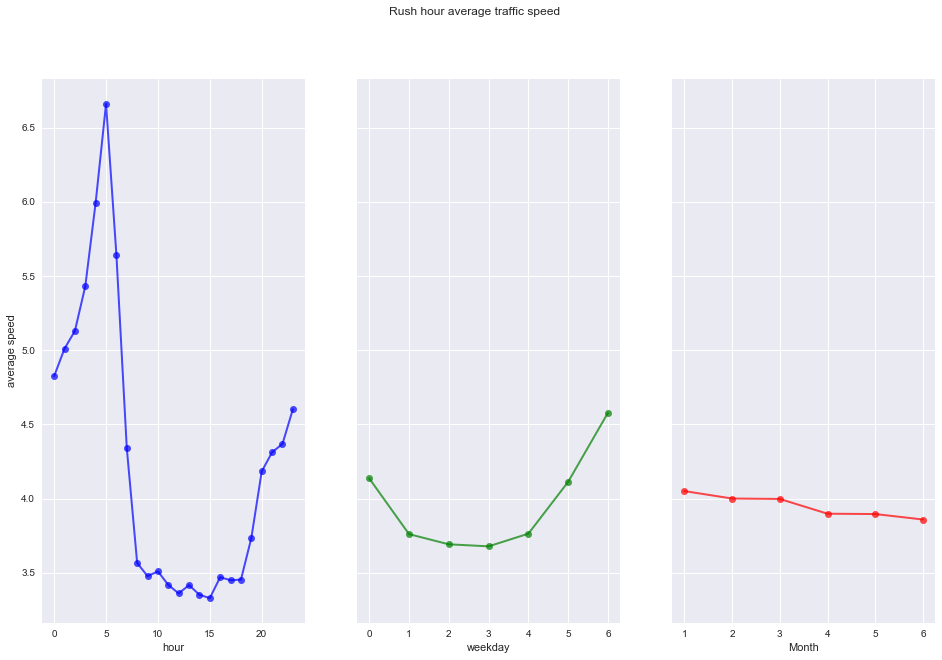

In [102]:
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('Hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('dayofweek').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('Month').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('Month')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

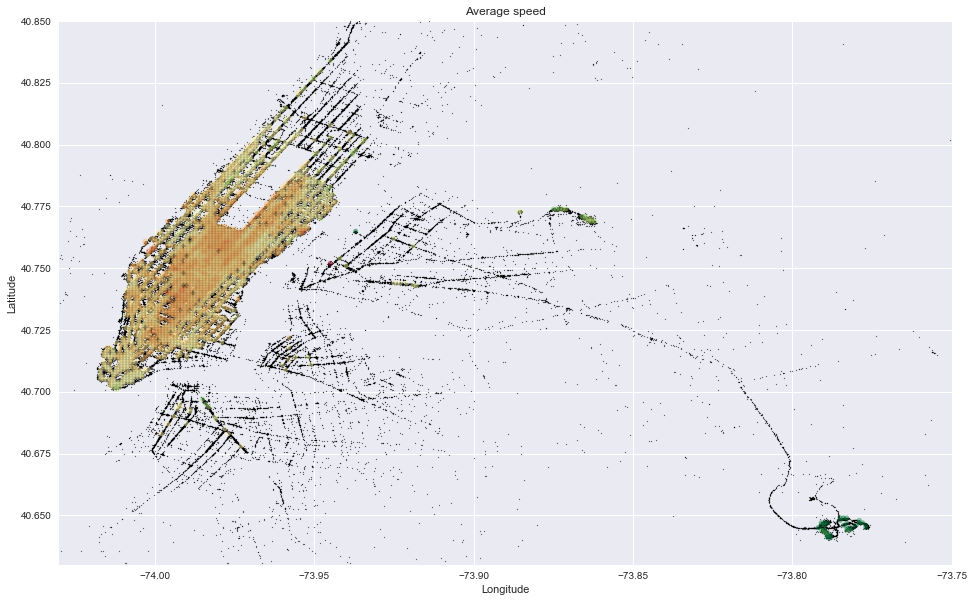

In [103]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], color='black', s=1, alpha=0.5)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values, c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()

In [104]:
fr1 = pd.read_csv('F:/Mine/MachineLearning/ML_in_Python/ML-projects/kaggle-NYC_Taxi/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv', usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
fr2 = pd.read_csv('F:/Mine/MachineLearning/ML_in_Python/ML-projects/kaggle-NYC_Taxi/new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_street_info = pd.read_csv('F:/Mine/MachineLearning/ML_in_Python/ML-projects/kaggle-NYC_Taxi/new-york-city-taxi-with-osrm/fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
train_street_info = pd.concat((fr1, fr2))
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')

In [105]:
train.shape, test.shape

((1437128, 29), (625134, 22))

In [106]:
vendor_train = pd.get_dummies(train['vendor_id'], prefix='vi', prefix_sep='_')
vendor_test = pd.get_dummies(test['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(train['passenger_count'], prefix='pc', prefix_sep='_')
passenger_count_test = pd.get_dummies(test['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = pd.get_dummies(test['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
cluster_pickup_train = pd.get_dummies(train['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_pickup_test = pd.get_dummies(test['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_dropoff_train = pd.get_dummies(train['dropoff_cluster'], prefix='d', prefix_sep='_')
cluster_dropoff_test = pd.get_dummies(test['dropoff_cluster'], prefix='d', prefix_sep='_')

month_train = pd.get_dummies(train['Month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(test['Month'], prefix='m', prefix_sep='_')
dom_train = pd.get_dummies(train['DayofMonth'], prefix='dom', prefix_sep='_')
dom_test = pd.get_dummies(test['DayofMonth'], prefix='dom', prefix_sep='_')
hour_train = pd.get_dummies(train['Hour'], prefix='h', prefix_sep='_')
hour_test = pd.get_dummies(test['Hour'], prefix='h', prefix_sep='_')
dow_train = pd.get_dummies(train['dayofweek'], prefix='dow', prefix_sep='_')
dow_test = pd.get_dummies(test['dayofweek'], prefix='dow', prefix_sep='_')

In [107]:
passenger_count_test = passenger_count_test.drop('pc_9', axis = 1)

In [108]:
train = train.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','dayofweek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis = 1)
Test_id = test['id']
test = test.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','dayofweek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis = 1)

train = train.drop(['dropoff_datetime','avg_speed_h','avg_speed_m','pickup_lat_bin','pickup_long_bin','trip_duration'], axis = 1)

In [109]:
train.shape,test.shape

((1437128, 11), (625134, 10))

In [110]:
train.head()

,pickup_datetime,pickup_date,log_trip_duration,distance_haversine,distance_dummy_manhattan,direction,pickup_cluster,dropoff_cluster,total_distance,total_travel_time,number_of_steps
0,2016-03-14 17:24:55,2016-03-14,6.122493,1.498521,1.735433,99.970196,96,83,2009.1,164.9,5.0
1,2016-06-12 00:43:35,2016-06-12,6.498282,1.805507,2.430506,-117.153768,12,92,2513.2,332.0,6.0
2,2016-01-19 11:35:24,2016-01-19,7.661527,6.385098,8.203575,-159.680165,47,8,11060.8,767.6,16.0
3,2016-04-06 19:32:31,2016-04-06,6.063785,1.485498,1.661331,-172.737700,27,8,1779.4,235.8,4.0
4,2016-03-26 13:30:55,2016-03-26,6.077642,1.188588,1.199457,179.473585,39,84,1614.9,140.1,5.0


In [111]:
train = train.drop(['pickup_cluster','dropoff_cluster'],axis = 1)
test = test.drop(['pickup_cluster','dropoff_cluster'],axis=1)

In [112]:
Train_Master = pd.concat([train,
                          vendor_train,
                          passenger_count_train,
                          store_and_fwd_flag_train,
                          cluster_pickup_train,
                          cluster_dropoff_train,
                         month_train,
                         dom_train,
                          hour_train,
                          dow_train
                         ], axis=1)

In [113]:
Test_master = pd.concat([test, 
                         vendor_test,
                         passenger_count_test,
                         store_and_fwd_flag_test,
                         cluster_pickup_test,
                         cluster_dropoff_test,
                         month_test,
                         dom_test,
                          hour_test,
                          dow_test], axis=1)

In [114]:
Train_Master.shape,Test_master.shape

((1437128, 288), (625134, 287))

In [115]:
Train_Master['year']  = Train_Master['pickup_datetime'].dt.year
Train_Master['month'] = Train_Master['pickup_datetime'].dt.month
Train_Master['day']   = Train_Master['pickup_datetime'].dt.day
Train_Master['hr']    = Train_Master['pickup_datetime'].dt.hour

Test_master['year']  = Test_master['pickup_datetime'].dt.year
Test_master['month'] = Test_master['pickup_datetime'].dt.month
Test_master['day']   = Test_master['pickup_datetime'].dt.day
Test_master['hr']    = Test_master['pickup_datetime'].dt.hour

Train_Master.head()

,pickup_datetime,pickup_date,log_trip_duration,distance_haversine,distance_dummy_manhattan,direction,total_distance,total_travel_time,number_of_steps,vi_1,...,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,year,month,day,hr
0,2016-03-14 17:24:55,2016-03-14,6.122493,1.498521,1.735433,99.970196,2009.1,164.9,5.0,0,...,0,0,0,0,0,0,2016,3,14,17
1,2016-06-12 00:43:35,2016-06-12,6.498282,1.805507,2.430506,-117.153768,2513.2,332.0,6.0,1,...,0,0,0,0,0,1,2016,6,12,0
2,2016-01-19 11:35:24,2016-01-19,7.661527,6.385098,8.203575,-159.680165,11060.8,767.6,16.0,0,...,1,0,0,0,0,0,2016,1,19,11
3,2016-04-06 19:32:31,2016-04-06,6.063785,1.485498,1.661331,-172.737700,1779.4,235.8,4.0,0,...,0,1,0,0,0,0,2016,4,6,19
4,2016-03-26 13:30:55,2016-03-26,6.077642,1.188588,1.199457,179.473585,1614.9,140.1,5.0,0,...,0,0,0,0,1,0,2016,3,26,13


In [116]:
Test_master.head()

,pickup_datetime,pickup_date,distance_haversine,distance_dummy_manhattan,direction,total_distance,total_travel_time,number_of_steps,vi_1,vi_2,...,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,year,month,day,hr
0,2016-06-30 23:59:58,2016-06-30,2.746426,2.913304,-3.595224,3795.9,424.6,4,1,0,...,0,0,1,0,0,0,2016,6,30,23
1,2016-06-30 23:59:53,2016-06-30,2.759239,3.104805,172.278835,2904.5,200.0,4,1,0,...,0,0,1,0,0,0,2016,6,30,23
2,2016-06-30 23:59:47,2016-06-30,1.306155,1.846340,133.326248,1499.5,193.2,4,1,0,...,0,0,1,0,0,0,2016,6,30,23
3,2016-06-30 23:59:41,2016-06-30,5.269088,7.163347,-150.956833,7023.9,494.8,11,0,1,...,0,0,1,0,0,0,2016,6,30,23
4,2016-06-30 23:59:33,2016-06-30,0.960842,1.354164,130.260381,1108.2,103.2,4,1,0,...,0,0,1,0,0,0,2016,6,30,23


In [117]:
Train_Master = Train_Master.drop(['pickup_datetime','pickup_date'],axis = 1)
Test_master = Test_master.drop(['pickup_datetime','pickup_date'],axis = 1)

In [118]:
#Train, Test = train_test_split(Train_Master[0:10000], test_size = 0.3)

Train, Test = train_test_split(Train_Master, test_size = 0.3)

In [119]:
Train.head()

,log_trip_duration,distance_haversine,distance_dummy_manhattan,direction,total_distance,total_travel_time,number_of_steps,vi_1,vi_2,pc_0,...,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,year,month,day,hr
249919,6.025866,3.210924,3.908394,-165.597166,3912.1,544.2,10.0,0,1,0,...,0,0,0,0,0,1,2016,6,5,23
1345331,5.560682,0.820048,1.144080,125.582658,1087.4,103.9,5.0,1,0,0,...,0,0,1,0,0,0,2016,2,11,10
1230754,6.198479,2.431777,3.419190,51.183578,3188.8,264.8,5.0,1,0,0,...,0,0,0,0,0,1,2016,6,19,3
38392,6.102559,1.306593,1.784985,149.973982,2446.4,298.3,9.0,0,1,0,...,0,1,0,0,0,0,2016,1,6,17
22596,6.040255,1.362469,1.612535,168.184539,1890.5,249.9,5.0,1,0,0,...,0,0,0,0,0,0,2016,3,14,14


In [120]:
X_train = Train.drop(['log_trip_duration'], axis=1)
Y_train = Train["log_trip_duration"]
X_test = Test.drop(['log_trip_duration'], axis=1)
Y_test = Test["log_trip_duration"]

Y_test = Y_test.reset_index().drop('index',axis = 1)
Y_train = Y_train.reset_index().drop('index',axis = 1)

In [121]:
X_train.describe()

,distance_haversine,distance_dummy_manhattan,direction,total_distance,total_travel_time,number_of_steps,vi_1,vi_2,pc_0,pc_1,...,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,year,month,day,hr
count,1.005989e+06,1.005989e+06,1.005989e+06,1.005989e+06,1.005989e+06,1.005989e+06,1.005989e+06,1.005989e+06,1.005989e+06,1.005989e+06,...,1.005989e+06,1.005989e+06,1.005989e+06,1.005989e+06,1.005989e+06,1.005989e+06,1005989.0,1.005989e+06,1.005989e+06,1.005989e+06
mean,3.291808e+00,4.258008e+00,-1.569668e+01,4.438173e+03,3.804879e+02,7.443062e+00,4.654017e-01,5.345983e-01,2.982140e-05,7.088577e-01,...,1.391268e-01,1.441447e-01,1.502521e-01,1.532601e-01,1.514917e-01,1.334567e-01,2016.0,3.514570e+00,1.550269e+01,1.361800e+01
std,3.659479e+00,4.896532e+00,1.046539e+02,4.945382e+03,3.006311e+02,4.315913e+00,4.988018e-01,4.988018e-01,5.460819e-03,4.542892e-01,...,3.460789e-01,3.512366e-01,3.573186e-01,3.602382e-01,3.585277e-01,3.400679e-01,0.0,1.681309e+00,8.701558e+00,6.381201e+00
min,0.000000e+00,0.000000e+00,-1.799918e+02,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2016.0,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.224354e+00,1.561150e+00,-1.259841e+02,1.656400e+03,1.806000e+02,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2016.0,2.000000e+00,8.000000e+00,9.000000e+00
50%,2.067625e+00,2.656145e+00,8.062327e+00,2.722500e+03,2.865000e+02,6.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2016.0,4.000000e+00,1.500000e+01,1.400000e+01
75%,3.767333e+00,4.863914e+00,5.396786e+01,4.965400e+03,4.803000e+02,9.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2016.0,5.000000e+00,2.300000e+01,1.900000e+01
max,2.719163e+01,3.823659e+01,1.800000e+02,4.064780e+04,2.064700e+03,3.900000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2016.0,6.000000e+00,3.100000e+01,2.300000e+01


In [122]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1005989 entries, 249919 to 11936
Columns: 289 entries, distance_haversine to hr
dtypes: float64(6), int64(4), uint8(279)
memory usage: 352.1 MB


In [123]:
X_train.loc[np.isnan(X_train['total_distance']),'total_distance'] = X_train['total_distance'].mean()
X_train.loc[np.isnan(X_train['total_travel_time']),'total_travel_time'] = X_train['total_travel_time'].mean()
X_train.loc[np.isnan(X_train['number_of_steps']),'number_of_steps'] = X_train['number_of_steps'].mean()

X_test.loc[np.isnan(X_test['total_distance']),'total_distance'] = X_test['total_distance'].mean()
X_test.loc[np.isnan(X_test['total_travel_time']),'total_travel_time'] = X_test['total_travel_time'].mean()
X_test.loc[np.isnan(X_test['number_of_steps']),'number_of_steps'] = X_test['number_of_steps'].mean()

In [124]:
print 'There are %d rows that have missing values'%sum(Test_master.isnull().any(axis=1))

There are 0 rows that have missing values


In [125]:
weather = pd.read_csv('F:/Mine/MachineLearning/ML_in_Python/ML-projects/kaggle-NYC_Taxi/NYC_weather/KNYC_Metars.csv', parse_dates=['Time'])
weather.head()

,Time,Temp.,Windchill,Heat Index,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,None,Overcast
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,None,Overcast
2,2015-12-31 04:00:00,7.2,NaN,NaN,0.90,1016.7,5.6,12.9,Calm,0.0,0.0,0.0,None,Overcast
3,2015-12-31 05:00:00,7.2,5.9,NaN,0.86,1015.9,5.0,14.5,NW,7.4,0.0,0.0,None,Overcast
4,2015-12-31 06:00:00,7.2,6.4,NaN,0.90,1016.2,5.6,11.3,West,5.6,0.0,0.0,None,Overcast


In [126]:
weather['snow']= 1*(weather.Events=='Snow') + 1*(weather.Events=='Fog\n\t,\nSnow')
weather['year'] = weather['Time'].dt.year
weather['month'] = weather['Time'].dt.month
weather['day'] = weather['Time'].dt.day
weather['hr'] = weather['Time'].dt.hour
weather = weather[weather['year'] == 2016][['month','day','hr','Temp.','Precip','snow','Visibility']]

In [127]:
weather.head()

,month,day,hr,Temp.,Precip,snow,Visibility
22,1,1,0,5.6,0.0,0,16.1
23,1,1,1,5.6,0.0,0,16.1
24,1,1,2,5.6,0.0,0,16.1
25,1,1,3,5.0,0.0,0,16.1
26,1,1,4,5.0,0.0,0,16.1


In [128]:
print 'There are %d rows that have missing values'%sum(weather.isnull().any(axis=1))

There are 237 rows that have missing values


In [129]:
X_train = pd.merge(X_train, weather, on = ['month', 'day', 'hr'], how = 'left')
X_test = pd.merge(X_test, weather, on = ['month', 'day', 'hr'], how = 'left')

Test_master= pd.merge(Test_master, weather, on = ['month', 'day', 'hr'], how = 'left')

X_train.head()

,distance_haversine,distance_dummy_manhattan,direction,total_distance,total_travel_time,number_of_steps,vi_1,vi_2,pc_0,pc_1,...,dow_5,dow_6,year,month,day,hr,Temp.,Precip,snow,Visibility
0,3.210924,3.908394,-165.597166,3912.1,544.2,10.0,0,1,0,0,...,0,1,2016,6,5,23,19.4,0.0,0.0,12.9
1,0.820048,1.144080,125.582658,1087.4,103.9,5.0,1,0,0,1,...,0,0,2016,2,11,10,-5.0,0.0,0.0,16.1
2,2.431777,3.419190,51.183578,3188.8,264.8,5.0,1,0,0,1,...,0,1,2016,6,19,3,21.7,0.0,0.0,16.1
3,1.306593,1.784985,149.973982,2446.4,298.3,9.0,0,1,0,1,...,0,0,2016,1,6,17,3.9,0.0,0.0,16.1
4,1.362469,1.612535,168.184539,1890.5,249.9,5.0,1,0,0,1,...,0,0,2016,3,14,14,6.1,0.0,0.0,9.7


In [130]:
X_train = X_train.drop(['year','month','day','hr'],axis=1)
X_train.head()

,distance_haversine,distance_dummy_manhattan,direction,total_distance,total_travel_time,number_of_steps,vi_1,vi_2,pc_0,pc_1,...,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,Temp.,Precip,snow,Visibility
0,3.210924,3.908394,-165.597166,3912.1,544.2,10.0,0,1,0,0,...,0,0,0,0,0,1,19.4,0.0,0.0,12.9
1,0.820048,1.144080,125.582658,1087.4,103.9,5.0,1,0,0,1,...,0,0,1,0,0,0,-5.0,0.0,0.0,16.1
2,2.431777,3.419190,51.183578,3188.8,264.8,5.0,1,0,0,1,...,0,0,0,0,0,1,21.7,0.0,0.0,16.1
3,1.306593,1.784985,149.973982,2446.4,298.3,9.0,0,1,0,1,...,0,1,0,0,0,0,3.9,0.0,0.0,16.1
4,1.362469,1.612535,168.184539,1890.5,249.9,5.0,1,0,0,1,...,0,0,0,0,0,0,6.1,0.0,0.0,9.7


In [131]:
X_test = X_test.drop(['year','month','day','hr'],axis=1)
X_test.head()

,distance_haversine,distance_dummy_manhattan,direction,total_distance,total_travel_time,number_of_steps,vi_1,vi_2,pc_0,pc_1,...,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,Temp.,Precip,snow,Visibility
0,0.511538,0.683064,154.226550,642.0,92.4,5.0,1,0,0,1,...,0,1,0,0,0,0,3.9,0.0,0.0,16.1
1,6.416253,9.068562,136.685166,7891.1,678.6,13.0,1,0,0,1,...,0,1,0,0,0,0,20.0,0.0,0.0,16.1
2,1.256876,1.267014,-90.459206,1744.1,202.0,6.0,0,1,0,0,...,0,1,0,0,0,0,16.7,0.0,0.0,16.1
3,2.452855,2.601570,93.579634,3852.7,315.0,8.0,1,0,0,1,...,0,0,0,0,0,0,0.0,0.3,1.0,2.4
4,6.648217,9.221636,33.701901,8633.5,616.1,10.0,1,0,0,1,...,0,0,1,0,0,0,1.1,0.0,0.0,16.1


In [132]:
Test_master = Test_master.drop(['year','month','day','hr'],axis=1)
Test_master.head()

,distance_haversine,distance_dummy_manhattan,direction,total_distance,total_travel_time,number_of_steps,vi_1,vi_2,pc_0,pc_1,...,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,Temp.,Precip,snow,Visibility
0,2.746426,2.913304,-3.595224,3795.9,424.6,4,1,0,0,1,...,0,0,1,0,0,0,24.4,0.0,0.0,16.1
1,2.759239,3.104805,172.278835,2904.5,200.0,4,1,0,0,1,...,0,0,1,0,0,0,24.4,0.0,0.0,16.1
2,1.306155,1.846340,133.326248,1499.5,193.2,4,1,0,0,1,...,0,0,1,0,0,0,24.4,0.0,0.0,16.1
3,5.269088,7.163347,-150.956833,7023.9,494.8,11,0,1,0,1,...,0,0,1,0,0,0,24.4,0.0,0.0,16.1
4,0.960842,1.354164,130.260381,1108.2,103.2,4,1,0,0,1,...,0,0,1,0,0,0,24.4,0.0,0.0,16.1


In [133]:
X_train.describe()

,distance_haversine,distance_dummy_manhattan,direction,total_distance,total_travel_time,number_of_steps,vi_1,vi_2,pc_0,pc_1,...,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,Temp.,Precip,snow,Visibility
count,1.005989e+06,1.005989e+06,1.005989e+06,1.005989e+06,1.005989e+06,1.005989e+06,1.005989e+06,1.005989e+06,1.005989e+06,1.005989e+06,...,1.005989e+06,1.005989e+06,1.005989e+06,1.005989e+06,1.005989e+06,1.005989e+06,997706.000000,997706.000000,997706.000000,967007.000000
mean,3.291808e+00,4.258008e+00,-1.569668e+01,4.438173e+03,3.804879e+02,7.443062e+00,4.654017e-01,5.345983e-01,2.982140e-05,7.088577e-01,...,1.391268e-01,1.441447e-01,1.502521e-01,1.532601e-01,1.514917e-01,1.334567e-01,11.056780,0.068333,0.009004,14.693138
std,3.659479e+00,4.896532e+00,1.046539e+02,4.945382e+03,3.006311e+02,4.315913e+00,4.988018e-01,4.988018e-01,5.460819e-03,4.542892e-01,...,3.460789e-01,3.512366e-01,3.573186e-01,3.602382e-01,3.585277e-01,3.400679e-01,9.138849,0.466906,0.094460,3.100908
min,0.000000e+00,0.000000e+00,-1.799918e+02,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-18.300000,0.000000,0.000000,0.400000
25%,1.224354e+00,1.561150e+00,-1.259841e+02,1.656400e+03,1.806000e+02,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.900000,0.000000,0.000000,14.500000
50%,2.067625e+00,2.656145e+00,8.062327e+00,2.722500e+03,2.865000e+02,6.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,10.600000,0.000000,0.000000,16.100000
75%,3.767333e+00,4.863914e+00,5.396786e+01,4.965400e+03,4.803000e+02,9.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,18.000000,0.000000,0.000000,16.100000
max,2.719163e+01,3.823659e+01,1.800000e+02,4.064780e+04,2.064700e+03,3.900000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,32.200000,11.900000,1.000000,16.100000


In [134]:
X_train.loc[np.isnan(X_train['Temp.']),'Temp.'] = X_train['Temp.'].mean()
X_train.loc[np.isnan(X_train['Precip']),'Precip'] = X_train['Precip'].mean()
X_train.loc[np.isnan(X_train['snow']),'snow'] = X_train['snow'].mean()
X_train.loc[np.isnan(X_train['Visibility']),'Visibility'] = X_train['Visibility'].mean()

X_test.loc[np.isnan(X_test['Temp.']),'Temp.'] = X_test['Temp.'].mean()
X_test.loc[np.isnan(X_test['Precip']),'Precip'] = X_test['Precip'].mean()
X_test.loc[np.isnan(X_test['snow']),'snow'] = X_test['snow'].mean()
X_test.loc[np.isnan(X_test['Visibility']),'Visibility'] = X_test['Visibility'].mean()

Test_master.loc[np.isnan(Test_master['Temp.']),'Temp.'] = Test_master['Temp.'].mean()
Test_master.loc[np.isnan(Test_master['Precip']),'Precip'] = Test_master['Precip'].mean()
Test_master.loc[np.isnan(Test_master['snow']),'snow'] = Test_master['snow'].mean()
Test_master.loc[np.isnan(Test_master['Visibility']),'Visibility'] = Test_master['Visibility'].mean()

In [135]:
print 'There are %d rows that have missing values'%sum(X_train.isnull().any(axis=1))

There are 0 rows that have missing values


In [136]:
print 'There are %d rows that have missing values'%sum(X_test.isnull().any(axis=1))

There are 0 rows that have missing values


In [137]:
print 'There are %d rows that have missing values'%sum(Test_master.isnull().any(axis=1))

There are 0 rows that have missing values


In [138]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)
dtest = xgb.DMatrix(Test_master)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [139]:
#md = [6,7,8]
#lr = [0.1,0.3]
#mcw = [20,25,30]
#for m in md:
#    for l in lr:
#        for n in mcw:
#            t0 = datetime.now()
#            xgb_pars = {'min_child_weight': n, 'eta': l, 'colsample_bytree': 0.8, 
#                        'max_depth': m,
#            'subsample': 0.5, 'lambda': 3, 'nthread': -1, 'booster' : 'gbtree', 'silent': 0,
#            'eval_metric': 'rmse', 'objective': 'reg:linear'}
#            model = xgb.train(xgb_pars, dtrain, 100, watchlist, early_stopping_rounds=10,
#                  maximize=False, verbose_eval=1)
#            print m,l,n

In [140]:
xgb_pars = {'min_child_weight': 10, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 15,
'subsample': 0.9, 'lambda': 3, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, dtrain, 300, watchlist, early_stopping_rounds=10,
      maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model.best_score)

Will train until valid error hasn't decreased in 10 rounds.
[0]	train-rmse:5.402269	valid-rmse:5.402773
[1]	train-rmse:4.865587	valid-rmse:4.866239
[2]	train-rmse:4.383111	valid-rmse:4.383644
[3]	train-rmse:3.949100	valid-rmse:3.949680
[4]	train-rmse:3.558883	valid-rmse:3.559512
[5]	train-rmse:3.208135	valid-rmse:3.208820
[6]	train-rmse:2.892822	valid-rmse:2.893559
[7]	train-rmse:2.609621	valid-rmse:2.610383
[8]	train-rmse:2.355145	valid-rmse:2.356001
[9]	train-rmse:2.126661	valid-rmse:2.127675
[10]	train-rmse:1.921718	valid-rmse:1.922866
[11]	train-rmse:1.737874	valid-rmse:1.739203
[12]	train-rmse:1.573114	valid-rmse:1.574679
[13]	train-rmse:1.425599	valid-rmse:1.427447
[14]	train-rmse:1.293588	valid-rmse:1.295694
[15]	train-rmse:1.175759	valid-rmse:1.178204
[16]	train-rmse:1.070667	valid-rmse:1.073510
[17]	train-rmse:0.977034	valid-rmse:0.980302
[18]	train-rmse:0.893780	valid-rmse:0.897599
[19]	train-rmse:0.820015	valid-rmse:0.824378
[20]	train-rmse:0.754694	valid-rmse:0.759774
[21]	

Modeling RMSLE 0.33522


[311]	train-rmse:0.259723	valid-rmse:0.335245
Stopping. Best iteration:
[301]	train-rmse:0.260573	valid-rmse:0.335222



In [141]:
#xgb.plot_importance(model, max_number_features=28, height=0.7)

In [142]:
pred = model.predict(dtest)
pred = np.exp(pred) - 1

In [143]:
submission = pd.concat([Test_id, pd.DataFrame(pred)], axis=1)
submission.columns = ['id','trip_duration']
submission['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
submission.to_csv("NYC_Taxi_Trip_Duration_1.10.csv", index=False)

In [144]:
print time.strftime( ISOTIMEFORMAT, time.localtime( time.time() ) )

2017-08-24 23:36:02
